# Dependencies  

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch 
import torch.optim as optim
from torch.utils.data import Dataset, Subset
from torch.utils.data import random_split
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import time

# Preprocessing

In [4]:
transformation_done = transforms.Compose( [transforms.Resize((32,32)), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                          std=[0.5, 0.5, 0.5])])

#change average sizes
#grabbing dataset
dataset = torchvision.datasets.ImageFolder('dataset', 
                                                transform=transformation_done)

#randomly splitting for training and testing
training_set, testing_set = random_split(dataset, [2328, 998])


                                                
training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True, num_workers=2)
testing_set_loader = torch.utils.data.DataLoader(testing_set, batch_size=100, shuffle=True, num_workers=2)

# Baseline - Logistic Regression

In [5]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.linear(x)
        return x

model = LogisticRegression(input_size=3072, num_classes=10)
criterion_done = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(30):
    for i, (images, labels) in enumerate(training_set_loader):
        # Reshape images to (batch_size, input_size)
        images = images.view(-1, 3072)
        
        # Forward pass
        outputs = model(images)
        loss = criterion_done(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/100], Step [{i+1}/{len(training_set_loader)}], Loss: {loss.item():.4f}')

# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testing_set_loader:
        images = images.view(-1, 3072)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test set: {100 * correct / total} %')

Accuracy of the model on the test set: 38.57715430861723 %


# CNN architecture

In [6]:
#building neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 64, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


# Training CNN 

#### Hyperparameters|

In [7]:
num_epochs = 12
num_classes = 10
learning_rate = 0.001

In [8]:
#initializing CNN
model = CNN()
criterion_done = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

### Runnings epochs

In [9]:
start = time.perf_counter()
total_step = len(training_set_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(training_set_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion_done(outputs, labels)
        loss_list.append(loss.item())
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
        (correct / total) * 100))
end = time.perf_counter()
print(f"{round(end-start,2)} seconds")

Epoch [1/12], Step [24/24], Loss: 1.7179, Accuracy: 32.14%
Epoch [2/12], Step [24/24], Loss: 1.4011, Accuracy: 46.43%
Epoch [3/12], Step [24/24], Loss: 1.4342, Accuracy: 57.14%
Epoch [4/12], Step [24/24], Loss: 1.2459, Accuracy: 53.57%
Epoch [5/12], Step [24/24], Loss: 0.8941, Accuracy: 64.29%
Epoch [6/12], Step [24/24], Loss: 1.1068, Accuracy: 60.71%
Epoch [7/12], Step [24/24], Loss: 1.1671, Accuracy: 60.71%
Epoch [8/12], Step [24/24], Loss: 0.8979, Accuracy: 67.86%
Epoch [9/12], Step [24/24], Loss: 0.7506, Accuracy: 75.00%
Epoch [10/12], Step [24/24], Loss: 0.9901, Accuracy: 57.14%
Epoch [11/12], Step [24/24], Loss: 0.8843, Accuracy: 60.71%
Epoch [12/12], Step [24/24], Loss: 0.6042, Accuracy: 78.57%
92.88 seconds


## Pikcled Model

In [21]:

load = torch.load("models/finalModel.pt")
#model = load #uncomment to use prerun model

# Model Evaluation

### Accuracy

In [11]:
#testing the model after it has beeen trained
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testing_set_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 1000 test images: {:.2f}%'
          .format((correct / total) * 100))

Test Accuracy of the model on the 1000 test images: 53.00%
Test Accuracy of the model on the 1000 test images: 57.50%
Test Accuracy of the model on the 1000 test images: 59.67%
Test Accuracy of the model on the 1000 test images: 63.50%
Test Accuracy of the model on the 1000 test images: 62.40%
Test Accuracy of the model on the 1000 test images: 63.83%
Test Accuracy of the model on the 1000 test images: 63.43%
Test Accuracy of the model on the 1000 test images: 63.50%
Test Accuracy of the model on the 1000 test images: 62.67%
Test Accuracy of the model on the 1000 test images: 62.63%


## Training Error 

Time to evaluate our data.
First will be the training data.


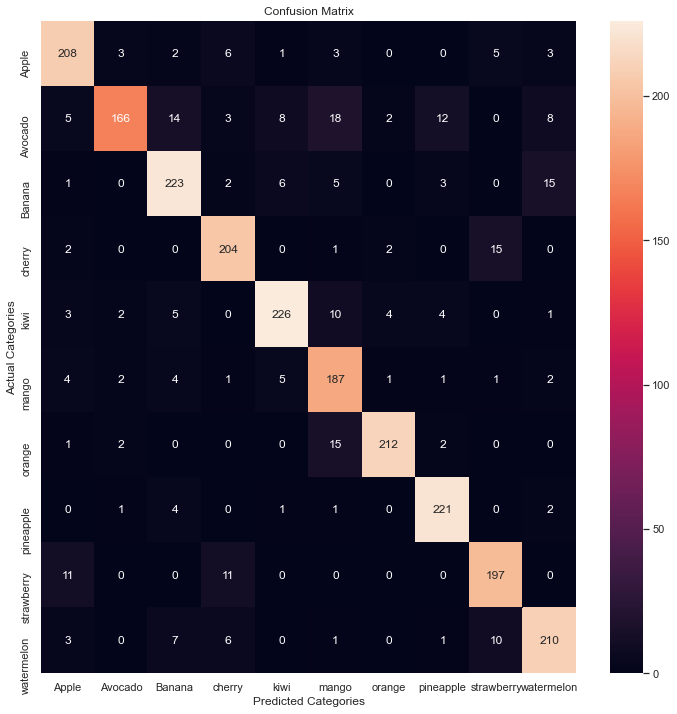

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       238
           1       0.70      0.94      0.81       176
           2       0.87      0.86      0.87       259
           3       0.91      0.88      0.89       233
           4       0.89      0.91      0.90       247
           5       0.90      0.78      0.83       241
           6       0.91      0.96      0.94       221
           7       0.96      0.91      0.93       244
           8       0.90      0.86      0.88       228
           9       0.88      0.87      0.88       241

    accuracy                           0.88      2328
   macro avg       0.88      0.88      0.88      2328
weighted avg       0.89      0.88      0.88      2328



In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

print("Time to evaluate our data.")
print("First will be the training data.")

#building Confusion Matrix as well as getting accuracy, predictions and F1 score for train model
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in training_set_loader:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
        
sns.set(rc={'figure.figsize':(12,12)})
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])
confusionMatrix.yaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])


plt.show()

#printing Accuracy, Prediction and F1 score for training model
print(classification_report(prediction_list, accurate_list))

## Testing Error

Now to evaluate the testing data.


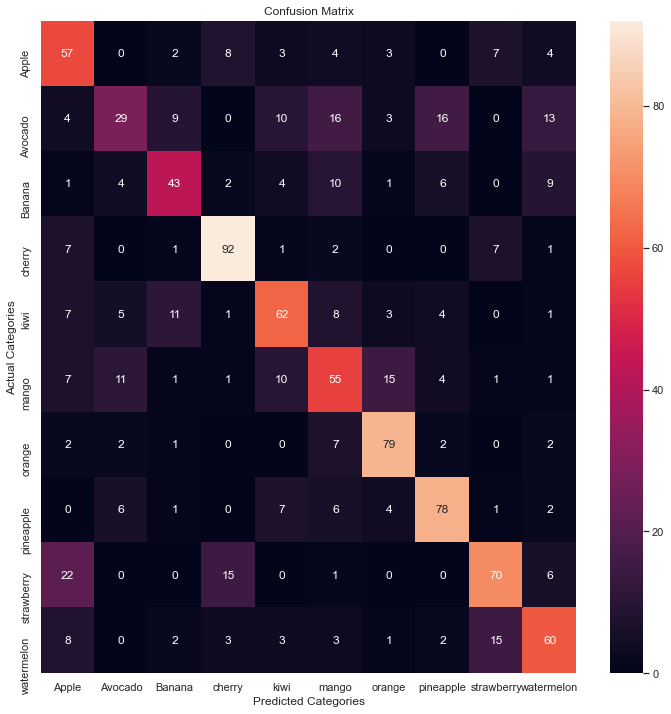

              precision    recall  f1-score   support

           0       0.65      0.50      0.56       115
           1       0.29      0.51      0.37        57
           2       0.54      0.61      0.57        71
           3       0.83      0.75      0.79       122
           4       0.61      0.62      0.61       100
           5       0.52      0.49      0.50       112
           6       0.83      0.72      0.77       109
           7       0.74      0.70      0.72       112
           8       0.61      0.69      0.65       101
           9       0.62      0.61      0.61        99

    accuracy                           0.63       998
   macro avg       0.62      0.62      0.62       998
weighted avg       0.65      0.63      0.63       998



In [13]:
#building Confusion Matrix as well as getting accuracy, predictions and F1 score for test model

print("Now to evaluate the testing data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in testing_set_loader:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())

sns.set(rc={'figure.figsize':(12,12)})

confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g')
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])
confusionMatrix.yaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))

# Cross-Validation - Takes alot of time to run

In [14]:
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

full_dataset = torchvision.datasets.ImageFolder('dataset', 
                                                transform=transformation_done)

full_loader=torch.utils.data.DataLoader(full_dataset, batch_size=1000, shuffle=True, num_workers=2)

kfold = KFold(n_splits=10, shuffle=True, random_state=None)
fold_value = 1
for training_id, testing_id in kfold.split(dataset):
   
    print("Fold Number:", fold_value)
    training_dataset = Subset(dataset, training_id)
    testing_dataset = Subset(dataset, testing_id)
    training_set_loader = torch.utils.data.DataLoader(training_dataset, batch_size=1000, shuffle=True, num_workers=2)
    testing_set_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=1000, shuffle=True, num_workers=2)
    total_step = len(training_set_loader)
    loss_list = []
    acc_list = []
    model = CNN()
    criterion_done = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 10
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(training_set_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion_done(outputs, labels)
            loss_list.append(loss.item())
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
            (correct / total) * 100))
    model.eval()
    prediction_list = []
    accurate_list = []
    with torch.no_grad():
        for images, labels in full_loader:
            outputs = model(images)
            _, predicted = torch.max(model(images), 1)
            prediction_list.extend(predicted.detach().cpu().numpy())
            accurate_list.extend(labels.detach().cpu().numpy())
    print(classification_report(prediction_list, accurate_list))
    fold_value+=1

Fold Number: 1
Epoch [1/10], Step [3/3], Loss: 2.5746, Accuracy: 13.70%
Epoch [2/10], Step [3/3], Loss: 2.0440, Accuracy: 27.19%
Epoch [3/10], Step [3/3], Loss: 1.8423, Accuracy: 31.02%
Epoch [4/10], Step [3/3], Loss: 1.6682, Accuracy: 33.53%
Epoch [5/10], Step [3/3], Loss: 1.5486, Accuracy: 40.18%
Epoch [6/10], Step [3/3], Loss: 1.4727, Accuracy: 44.31%
Epoch [7/10], Step [3/3], Loss: 1.3956, Accuracy: 46.53%
Epoch [8/10], Step [3/3], Loss: 1.3574, Accuracy: 48.54%
Epoch [9/10], Step [3/3], Loss: 1.3374, Accuracy: 51.06%
Epoch [10/10], Step [3/3], Loss: 1.2563, Accuracy: 54.08%
              precision    recall  f1-score   support

           0       0.08      0.79      0.15        33
           1       0.39      0.53      0.45       248
           2       0.64      0.39      0.49       549
           3       0.64      0.45      0.53       470
           4       0.62      0.44      0.52       504
           5       0.35      0.46      0.40       240
           6       0.56      0.84  

Epoch [3/10], Step [3/3], Loss: 1.7471, Accuracy: 33.50%
Epoch [4/10], Step [3/3], Loss: 1.6295, Accuracy: 38.83%
Epoch [5/10], Step [3/3], Loss: 1.4597, Accuracy: 47.48%
Epoch [6/10], Step [3/3], Loss: 1.4089, Accuracy: 49.70%
Epoch [7/10], Step [3/3], Loss: 1.3363, Accuracy: 50.60%
Epoch [8/10], Step [3/3], Loss: 1.2874, Accuracy: 52.11%
Epoch [9/10], Step [3/3], Loss: 1.2292, Accuracy: 56.14%
Epoch [10/10], Step [3/3], Loss: 1.1826, Accuracy: 56.74%
              precision    recall  f1-score   support

           0       0.40      0.50      0.45       255
           1       0.46      0.43      0.45       359
           2       0.50      0.55      0.53       303
           3       0.61      0.70      0.65       292
           4       0.72      0.48      0.57       541
           5       0.22      0.45      0.30       155
           6       0.53      0.70      0.60       245
           7       0.79      0.50      0.62       527
           8       0.52      0.54      0.53       321
  